<h1 style="color:#0077b6;text-align:center;font-size:50px">Web Scraping</h1>

Le web scraping est une technique d'extraction du contenu de sites Web, via un script ou un programme, dans le but de le transformer pour permettre son utilisation dans un autre contexte comme l'enrichissement de bases de données, le référencement ou l'exploration de données.

In [2]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
from requests import get
from time import sleep
from random import randint
from warnings import warn
import matplotlib.pyplot as plt
import pymongo as pym      # Interface with Python <--> MongoDB 
import os                  # find files on system
import csv                 
import json                # convert file to json format
import pprint

In [2]:
pages = np.arange(1, 20, 50) 
headers = {'Accept-Language': 'en-US,en;q=0.8'} # If this is not specified, the default language is Mandarin

In [3]:
#initialize empty lists to store the variables scraped
titles = []
years = []
ratings = []
genres = []
runtimes = []
imdb_ratings = []
metascores = []
votes = []

In [4]:
for page in pages:
    
    #get request
    response = get("https://www.imdb.com/search/title?genres=sci-fi&" 
                   + "start=" 
                   + str(page) 
                   + "&explore=title_type,genres&ref_=adv_prv")
    
    sleep(randint(8,15))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))

    #parse the content of current iteration of request
    page_html = BeautifulSoup(response.text, 'html.parser')
        
    movie_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')
    
    #extract the 50 movies for that page
    for container in movie_containers:

        #conditional for all with metascore
        if container.find('div', class_ = 'ratings-metascore') is not None:

            #title
            title = container.h3.a.text
            titles.append(title)

            #year released
            year = container.h3.find('span', class_= 'lister-item-year text-muted unbold').text
            years.append(year)

            #rating
            rating = container.p.find('span', class_= 'certificate').text
            ratings.append(rating)

            #genre
            genre = container.p.find('span', class_ = 'genre').text
            genres.append(genre)

            #runtime
            time = container.p.find('span', class_ = 'runtime').text
            runtimes.append(time)

            #IMDB ratings
            imdb = float(container.strong.text)
            imdb_ratings.append(imdb)

            #Metascore
            m_score = container.find('span', class_ = 'metascore').text
            metascores.append(int(m_score))

            #Number of votes
            vote = container.find('span', attrs = {'name':'nv'})['data-value']
            votes.append(int(vote))

In [5]:
sci_fi_df = pd.DataFrame({'movie': titles,
                      'year': years,
                      'rating': ratings,
                      'genre': genres,
                      'runtime_min': runtimes,
                      'imdb': imdb_ratings,
                      'metascore': metascores,
                      'votes': votes}
                      )

sci_fi_df.loc[:, 'year'] = sci_fi_df['year'].str[-5:-1] # two more data transformations after scraping
# Drop 'ovie' bug
# Make year an int
sci_fi_df['n_imdb'] = sci_fi_df['imdb'] * 10
final_df = sci_fi_df.loc[sci_fi_df['year'] != 'ovie'] # One small issue with the scrape on these two movies so just dropping those ones.
final_df.loc[:, 'year'] = pd.to_numeric(final_df['year'])

In [6]:
sci_fi_df

,movie,year,rating,genre,runtime_min,imdb,metascore,votes,n_imdb
0,Black Panther: Wakanda Forever,2022,PG-13,"\nAction, Adventure, Drama",161 min,7.2,67,113563,72.0
1,Strange World,2022,PG,"\nAnimation, Action, Adventure",102 min,4.8,65,9018,48.0
2,Black Adam,2022,PG-13,"\nAction, Adventure, Fantasy",125 min,6.7,41,156892,67.0
3,Everything Everywhere All at Once,2022,R,"\nAction, Adventure, Comedy",139 min,8.1,81,248112,81.0
4,Avatar,2009,PG-13,"\nAction, Adventure, Fantasy",162 min,7.8,83,1252003,78.0
5,Nope,2022,R,"\nHorror, Mystery, Sci-Fi",130 min,6.9,77,169317,69.0
6,Thor: Love and Thunder,2022,PG-13,"\nAction, Adventure, Comedy",118 min,6.3,57,318630,63.0
7,Black Panther,2018,PG-13,"\nAction, Adventure, Sci-Fi",134 min,7.3,88,769539,73.0
8,Rogue One,2016,PG-13,"\nAction, Adventure, Sci-Fi",133 min,7.8,65,637441,78.0
9,Guardians of the Galaxy,2014,PG-13,"\nAction, Adventure, Comedy",121 min,8.0,76,1176353,80.0


In [7]:
sci_fi_df.to_csv(r'C:\Users\ayari\OneDrive\Bureau\C-ISET\L3\Atelier_BaseDonnéeAvancé\MongoNotebook\DataSet.CSV')

In [8]:
# Create Dict() to send to MongoDB
sci_fi_df_dict =sci_fi_df.to_dict('records')
# fake_users_dict[:2]

<h1 style="color:#0077b6;text-align:center;font-size:50px">MongoDB-PyMongo-Tutoriel</h1>

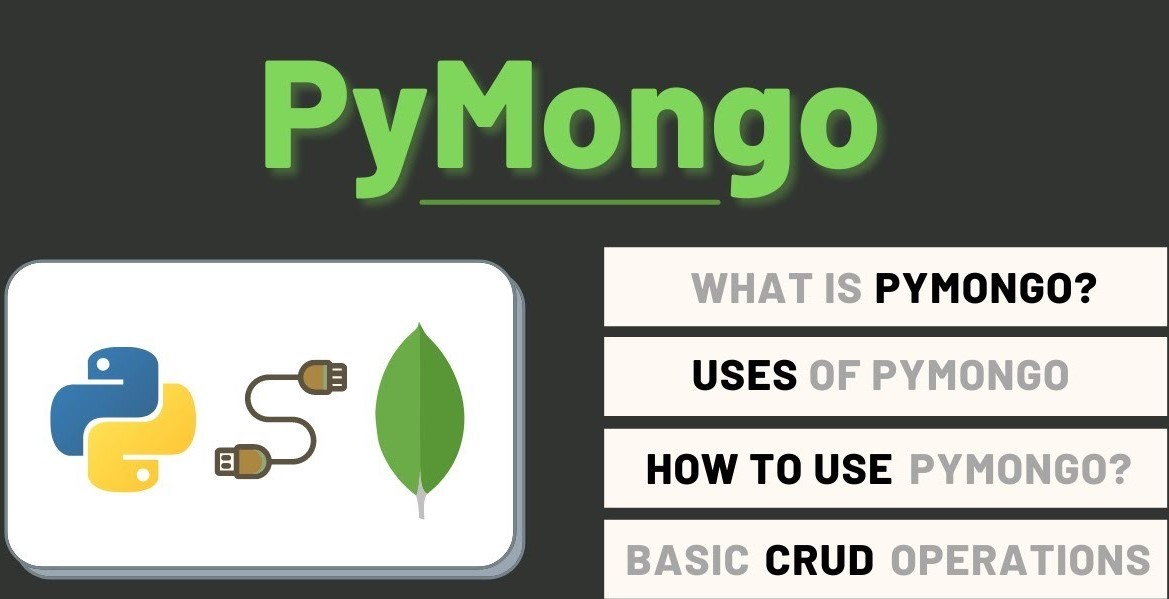

PyMongo is a Python distribution containing tools for working with MongoDB, and is the recommended way to work with MongoDB from Python.

To create a database in MongoDB, start by creating a MongoClient object, then specify a connection URL with the correct ip address and the name of the database you want to create.

MongoDB will create the database if it does not exist, and make a connection to it.

In [9]:
# Making a Connection to MongoClient
client = pym.MongoClient('mongodb://localhost:27017/')

# CREATING A DATABASE:
db = client["sci_fi_df"]

# CREATING A COLLECTION (*AKA* TABLE):
user_info_table= db["films"]

In [10]:
user_info_table.insert_many(sci_fi_df_dict)


In [11]:
#Displayeing the list of databases
client.list_database_names()

['L3DSI', 'STOCK', 'admin', 'config', 'local', 'sci_fi_df', 'world_cup']

In [12]:
DBName='sci_fi_df'
client[DBName].list_collection_names()

['films']

In [13]:
db=client[DBName]
films=db["films"]

In [14]:
#The nomber of documents in our collection 'films'
films.count_documents({})

17

# MongoDB Insert Document

To insert data into MongoDB collection, you need to use MongoDB's insert_one() or insert_many() method.

###### Syntax

The basic syntax of this two method is as follows −


>db.COLLECTION_NAME.insert_one(document)

>db.COLLECTION_NAME.insert_many(document)

###### Example

#### Insert_one()

In [15]:
rs=films.insert_one({
    "movie":"ONE PIECE - RED",
    "year":"2022",
    "rating":"PG-13",
    "genre":'\nAnimation, Aventure, Comédie',
    "runtime_min":"115",
    "imdb":8.7,
    "votes":197360
})

In [16]:
films.count_documents({})

18

##### Insert_many()

In [17]:
data=[
    {
        "movie":"MAESTRO(S)",
        "year":"2022",
        "rating":"PG-13",
        "genre":'\nDrama',
        "runtime_min":"87",
        "imdb":6.7,
        "votes":88395
    },
    {
        "movie":"AVATAR : LA VOIE DE L'EAU",
        "year":"2022",
        "rating":"PG-13",
        "genre":'\nScience fiction, Aventure',
        "runtime_min":"192",
        "imdb":7.9,
        "votes":33293
    },
    {
        "movie":"CORSAGE",
        "year":"2022",
        "rating":"PG-13",
        "genre":'\nDrame, Historique, Biopic',
        "runtime_min":"113",
        "imdb":6.9,
        "votes":34009
    },
    {
        "movie":"Samaritan",
        "year":"2022",
        "rating":"PG-13",
        "genre":'\nAction,Cinéma de fantasy',
        "runtime_min":"101",
        "imdb":8.7,
        "votes":101802
    },
    {
        "movie":"No Time to Die",
        "year":"2021 ",
        "rating":"PG-13",
        "genre":'\nAction,Thriller',
        "runtime_min":"163",
        "imdb":7.3,
        "votes":197433
    }
]

In [18]:
films.insert_many(data)
films.count_documents({})

23

# MongoDB Update Document

MongoDB's update() method is used to update document into a collection. 
It updates the values in the existing document.

###### Syntax:

>db.COLLECTION_NAME.update(SELECTION_CRITERIA, UPDATED_DATA)

###### Example:

In [19]:
#1) In this example , we will set the year of the movie 'AVATAR' to 2018.
rs=films.update_one({"movie":"Avatar"},{"$set":{'year':"2018"}})
print(rs.modified_count,"document updated")

1 document updated


In [20]:
#2) Here we will change the imdb to 10 and the metascore to 999 of the action movies.
rs=films.update_many({"genre":{'$regex':"Action"}},{"$set":{"imdb":10,"metascore":999}})
print(rs.modified_count,"document updated")

16 document updated


In [21]:
#3) Now we will add a new attribute in the film of 2019 that is stars and contain 4
rs=films.update_many({"year":"2019"},{"$set":{"stars":4}})
print(rs.modified_count,"document updated")

1 document updated


# MongoDB Delete document

The MongoDB shell provides the following methods to delete documents from a collection:

        To delete multiple documents, use db.collection.deleteMany().

        To delete a single document, use db.collection.deleteOne().

###### Example

In [22]:
#To delete the first document from the films collection where the year=2014
rs=films.delete_one({"year":"2014"})
print(rs.deleted_count,'document deleted')

1 document deleted


In [23]:
#Now we will do the same work but we will change one with many and see what will happend
rs=films.delete_many({"year":"2014"})
print(rs.deleted_count,'document deleted')

1 document deleted


In [24]:
#Now we will delete all the movies begennig with N.
#Sow first whe will print the number of document contain this criteria
x=0
for f in films.find({'movie':{"$regex":"^N"}},{"movie":True,"_id":False}):
    x=x+1
print(x)

2


In [25]:
#and we will delete this 5 documents
rs=films.delete_many({'movie':{"$regex":"^N"}})
print(rs.deleted_count,'document deleted')

2 document deleted


In [26]:
films.count_documents({})

19

# MongoDB Projection

In MongoDB, projection means selecting only the necessary data rather than selecting whole of the data of a document. If a document has 5 fields and you need to show only 3, then select only 3 fields from them.

##### The find() Method

MongoDB's find() method, explained in MongoDB Query Document accepts second optional parameter that is list of fields that you want to retrieve. In MongoDB, when you execute find() method, then it displays all fields of a document. To limit this, you need to set a list of fields with value 1 or 0. 1 is used to show the field while 0 is used to hide the fields.

###### Syntax

>db.COLLECTION_NAME.find({},{KEY:1})

In this selection we will use some comparision query selectors witch are :

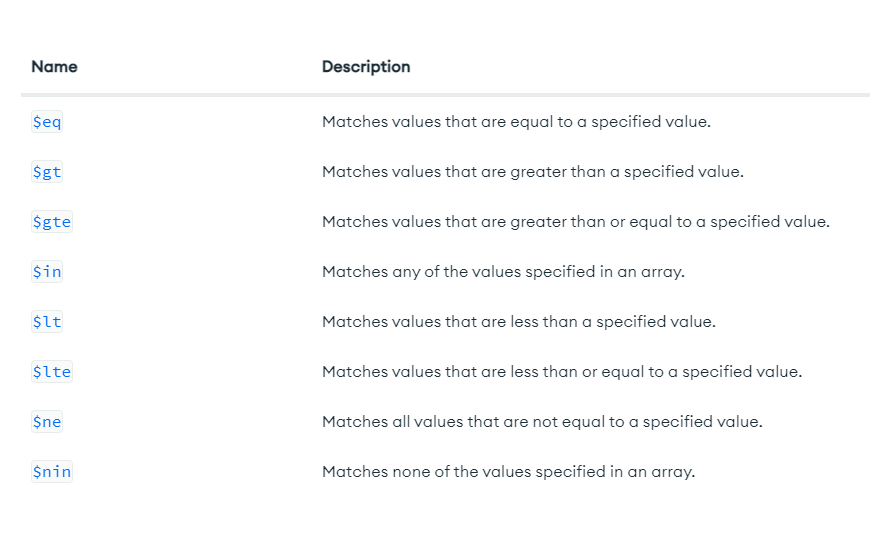

###### Example

In [27]:
#display all films 
for f in films.find({},{"movie":True,"imdb":1,"metascore":1,"_id":False}):
    print(f)

{'movie': 'Black Panther: Wakanda Forever', 'imdb': 10, 'metascore': 999}
{'movie': 'Strange World', 'imdb': 10, 'metascore': 999}
{'movie': 'Black Adam', 'imdb': 10, 'metascore': 999}
{'movie': 'Everything Everywhere All at Once', 'imdb': 10, 'metascore': 999}
{'movie': 'Avatar', 'imdb': 10, 'metascore': 999}
{'movie': 'Thor: Love and Thunder', 'imdb': 10, 'metascore': 999}
{'movie': 'Black Panther', 'imdb': 10, 'metascore': 999}
{'movie': 'Rogue One', 'imdb': 10, 'metascore': 999}
{'movie': 'Something in the Dirt', 'imdb': 6.0, 'metascore': 76}
{'movie': 'Dune: Part One', 'imdb': 10, 'metascore': 999}
{'movie': 'Spider-Man: No Way Home', 'imdb': 10, 'metascore': 999}
{'movie': 'Avengers: Endgame', 'imdb': 10, 'metascore': 999}
{'movie': 'Jurassic World: Dominion', 'imdb': 10, 'metascore': 999}
{'movie': 'Blade Runner 2049', 'imdb': 10, 'metascore': 999}
{'movie': 'ONE PIECE - RED', 'imdb': 8.7}
{'movie': 'MAESTRO(S)', 'imdb': 6.7}
{'movie': "AVATAR : LA VOIE DE L'EAU", 'imdb': 7.9}
{

In [28]:
#Display the movies witch their imdb note is higher 7
for f in films.find({"imdb" :{ "$gt" : 7}},{"_id":0,"movie":1,"year":1,"runtime_min":1}) : 
    print (f)

{'movie': 'Black Panther: Wakanda Forever', 'year': '2022', 'runtime_min': '161 min'}
{'movie': 'Strange World', 'year': '2022', 'runtime_min': '102 min'}
{'movie': 'Black Adam', 'year': '2022', 'runtime_min': '125 min'}
{'movie': 'Everything Everywhere All at Once', 'year': '2022', 'runtime_min': '139 min'}
{'movie': 'Avatar', 'year': '2018', 'runtime_min': '162 min'}
{'movie': 'Thor: Love and Thunder', 'year': '2022', 'runtime_min': '118 min'}
{'movie': 'Black Panther', 'year': '2018', 'runtime_min': '134 min'}
{'movie': 'Rogue One', 'year': '2016', 'runtime_min': '133 min'}
{'movie': 'Dune: Part One', 'year': '2021', 'runtime_min': '155 min'}
{'movie': 'Spider-Man: No Way Home', 'year': '2021', 'runtime_min': '148 min'}
{'movie': 'Avengers: Endgame', 'year': '2019', 'runtime_min': '181 min'}
{'movie': 'Jurassic World: Dominion', 'year': '2022', 'runtime_min': '147 min'}
{'movie': 'Blade Runner 2049', 'year': '2017', 'runtime_min': '164 min'}
{'movie': 'ONE PIECE - RED', 'year': '202

In [29]:
#Display the movies witch their imdb less than 8 and metascore less or equal to 100000
for f in films.find({"imdb" :{ "$lt" : 8},"metascore":{"$lte":130000}},{"_id":0,"movie":1,"year":1,"runtime_min":1,"imdb":1,'metascore':1}) : 
    print (f)

{'movie': 'Something in the Dirt', 'year': '2022', 'runtime_min': '116 min', 'imdb': 6.0, 'metascore': 76}


###### The Limit() Method

To limit the records in MongoDB, you need to use limit() method. The method accepts one number type argument, which is the number of documents that you want to be displayed.

###### Syntax

>db.COLLECTION_NAME.find().limit(NUMBER)

In [30]:
for f in films.find({},{'_id':0,"movie":1,'year':1,'rating':1,'runtime_min':1}).limit(5):
    print(f)

{'movie': 'Black Panther: Wakanda Forever', 'year': '2022', 'rating': 'PG-13', 'runtime_min': '161 min'}
{'movie': 'Strange World', 'year': '2022', 'rating': 'PG', 'runtime_min': '102 min'}
{'movie': 'Black Adam', 'year': '2022', 'rating': 'PG-13', 'runtime_min': '125 min'}
{'movie': 'Everything Everywhere All at Once', 'year': '2022', 'rating': 'R', 'runtime_min': '139 min'}
{'movie': 'Avatar', 'year': '2018', 'rating': 'PG-13', 'runtime_min': '162 min'}


###### The sort() Method

To sort documents in MongoDB, you need to use sort() method. The method accepts a document containing a list of fields along with their sorting order. To specify sorting order 1 and -1 are used. 1 is used for ascending order while -1 is used for descending order.

###### Syntax

>db.COLLECTION_NAME.find().sort({KEY:1})


In [31]:
for f in films.find({},{'_id':0,"movie":1,'year':1,'rating':1,'runtime_min':1,'imdb':1}).sort("imdb",1):
    print(f)

{'movie': 'Something in the Dirt', 'year': '2022', 'rating': 'R', 'runtime_min': '116 min', 'imdb': 6.0}
{'movie': 'MAESTRO(S)', 'year': '2022', 'rating': 'PG-13', 'runtime_min': '87', 'imdb': 6.7}
{'movie': 'CORSAGE', 'year': '2022', 'rating': 'PG-13', 'runtime_min': '113', 'imdb': 6.9}
{'movie': "AVATAR : LA VOIE DE L'EAU", 'year': '2022', 'rating': 'PG-13', 'runtime_min': '192', 'imdb': 7.9}
{'movie': 'ONE PIECE - RED', 'year': '2022', 'rating': 'PG-13', 'runtime_min': '115', 'imdb': 8.7}
{'movie': 'Black Panther: Wakanda Forever', 'year': '2022', 'rating': 'PG-13', 'runtime_min': '161 min', 'imdb': 10}
{'movie': 'Strange World', 'year': '2022', 'rating': 'PG', 'runtime_min': '102 min', 'imdb': 10}
{'movie': 'Black Adam', 'year': '2022', 'rating': 'PG-13', 'runtime_min': '125 min', 'imdb': 10}
{'movie': 'Everything Everywhere All at Once', 'year': '2022', 'rating': 'R', 'runtime_min': '139 min', 'imdb': 10}
{'movie': 'Avatar', 'year': '2018', 'rating': 'PG-13', 'runtime_min': '162 m

# MongoDB Array Type + Array of Record

MongoDB query array operator is used to query documents with an array, we can retrieve array element of data by using query array operator in MongoDB.

In [32]:
#Inserting documents contain an array
data=[
    {
        "movie":"MAESTRO(S)",
        "year":"2022",
        "rating":"PG-13",
        "genre":['Drama'],
        "actor":[{
            'first_name':"Nabha",
            'last_name':"Natech",
            'age':26
            },
            {
            'first_name':"Nithin",
            'last_name':"Kumar",
            'age':39
            },
            {
            'first_name':"Tamannaah",
            'last_name':"Bhatia",
            'age':32
            }
        ],
        "runtime_min":"87",
        "imdb":6.7,
        "votes":88395
    },
    {
        "movie":"AVATAR : LA VOIE DE L'EAU",
        "year":"2022",
        "rating":"PG-13",
        "genre":['Science fiction', 'Aventure'],
        "actor":[{
            'first_name':"Sam",
            'last_name':"Worthington",
            'age':46
            },
            {
            'first_name':"Zoe",
            'last_name':"Saldana",
            'age':44
            },
            {
            'first_name':"Sigourney",
            'last_name':"Weaver",
            'age':73
            }
        ],
        "runtime_min":"192",
        "imdb":7.9,
        "votes":33293
    },
    {
        "movie":"CORSAGE",
        "year":"2022",
        "rating":"PG-13",
        "genre":['Drame', 'Historique', 'Biopic'],
        "actor":[{
            'first_name':"Vicky",
            'last_name':"Krieps",
            'age':39
            },
            {
            'first_name':"Colin",
            'last_name':"Morgan",
            'age':36
            },
            {
            'first_name':"Alma",
            'last_name':"Hasun",
            'age':33
            }
        ],
        "runtime_min":"113",
        "imdb":6.9,
        "votes":34009
    },
]

In [33]:
films.insert_many(data)

In [34]:
for f in films.find({"movie" :{ "$in" : ["CORSAGE","AVATAR : LA VOIE DE L'EAU","MAESTRO(S)"]}},{"_id":0,'movie':1,'genre':1,"actor":1}):
    print(f)

{'movie': 'MAESTRO(S)', 'genre': '\nDrama'}
{'movie': "AVATAR : LA VOIE DE L'EAU", 'genre': '\nScience fiction, Aventure'}
{'movie': 'CORSAGE', 'genre': '\nDrame, Historique, Biopic'}
{'movie': 'MAESTRO(S)', 'genre': ['Drama'], 'actor': [{'first_name': 'Nabha', 'last_name': 'Natech', 'age': 26}, {'first_name': 'Nithin', 'last_name': 'Kumar', 'age': 39}, {'first_name': 'Tamannaah', 'last_name': 'Bhatia', 'age': 32}]}
{'movie': "AVATAR : LA VOIE DE L'EAU", 'genre': ['Science fiction', 'Aventure'], 'actor': [{'first_name': 'Sam', 'last_name': 'Worthington', 'age': 46}, {'first_name': 'Zoe', 'last_name': 'Saldana', 'age': 44}, {'first_name': 'Sigourney', 'last_name': 'Weaver', 'age': 73}]}
{'movie': 'CORSAGE', 'genre': ['Drame', 'Historique', 'Biopic'], 'actor': [{'first_name': 'Vicky', 'last_name': 'Krieps', 'age': 39}, {'first_name': 'Colin', 'last_name': 'Morgan', 'age': 36}, {'first_name': 'Alma', 'last_name': 'Hasun', 'age': 33}]}


In [35]:
#displaying the movies that the actors are less than 40 years old.
for f in films.find({'actor.age':{ "$lte": 40}},{"_id":0,'movie':1,'genre':1,"actor":1}):
    print(f)

{'movie': 'MAESTRO(S)', 'genre': ['Drama'], 'actor': [{'first_name': 'Nabha', 'last_name': 'Natech', 'age': 26}, {'first_name': 'Nithin', 'last_name': 'Kumar', 'age': 39}, {'first_name': 'Tamannaah', 'last_name': 'Bhatia', 'age': 32}]}
{'movie': 'CORSAGE', 'genre': ['Drame', 'Historique', 'Biopic'], 'actor': [{'first_name': 'Vicky', 'last_name': 'Krieps', 'age': 39}, {'first_name': 'Colin', 'last_name': 'Morgan', 'age': 36}, {'first_name': 'Alma', 'last_name': 'Hasun', 'age': 33}]}


# MongoDB Aggregation

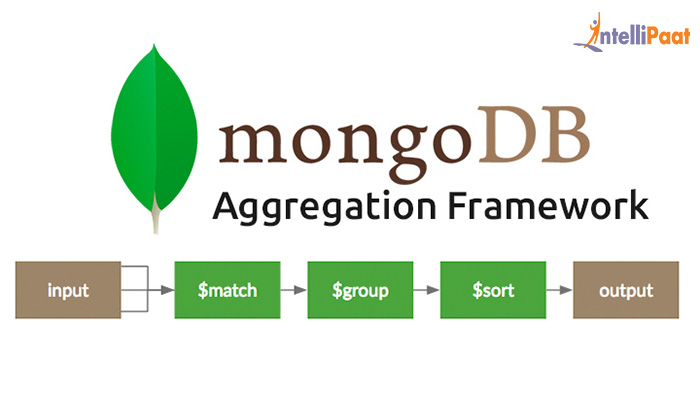

Aggregations operations process data records and return computed results. Aggregation operations group values from multiple documents together, and can perform a variety of operations on the grouped data to return a single result. In SQL count(*) and with group by is an equivalent of MongoDB aggregation.

###### The aggregate() Method

For the aggregation in MongoDB, you should use aggregate() method.

###### Syntax

>db.COLLECTION_NAME.aggregate(AGGREGATE_OPERATION)

In this table , we will find the most useless expression in the aggregation :

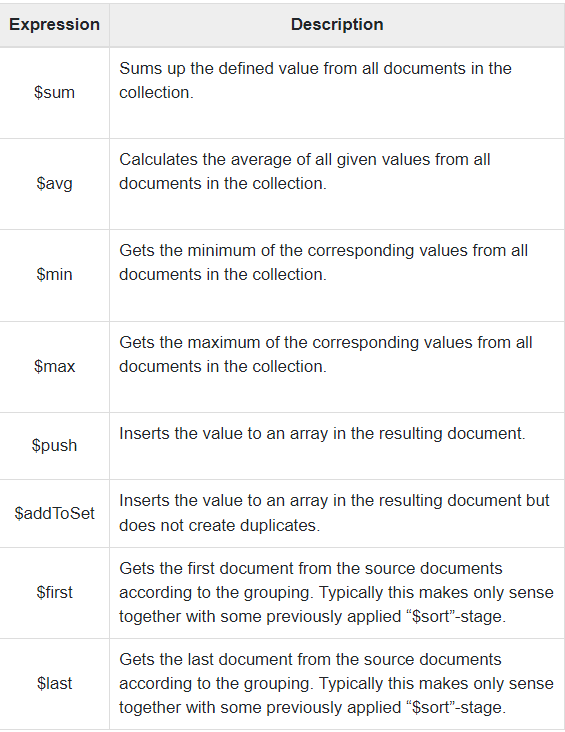

###### Example

In [36]:
#this expression will return the movies of 2021
for f in films.aggregate([{'$match':
                                   {
                                       'year':'2021'
                                   }     
                          }
                         ]
                        ):
    pprint.pprint(f)

{'_id': ObjectId('6394f37a6793a51043462394'),
 'genre': '\nAction, Adventure, Drama            ',
 'imdb': 10,
 'metascore': 999,
 'movie': 'Dune: Part One',
 'n_imdb': 80.0,
 'rating': 'PG-13',
 'runtime_min': '155 min',
 'votes': 629227,
 'year': '2021'}
{'_id': ObjectId('6394f37a6793a51043462395'),
 'genre': '\nAction, Adventure, Fantasy            ',
 'imdb': 10,
 'metascore': 999,
 'movie': 'Spider-Man: No Way Home',
 'n_imdb': 83.0,
 'rating': 'PG-13',
 'runtime_min': '148 min',
 'votes': 748728,
 'year': '2021'}


In [37]:
#this expression will return for all ther year the sum of imdb note
for f in films.aggregate([{'$group':
                                   {
                                       '_id':'$year',
                                       'sum of imdb : ':{
                                                           '$sum':'$imdb'
                                                       }
                                   }     
                          }
                         ]
                        ):
    pprint.pprint(f)

{'_id': '2021', 'sum of imdb : ': 20}
{'_id': '2017', 'sum of imdb : ': 10}
{'_id': '2016', 'sum of imdb : ': 10}
{'_id': '2018', 'sum of imdb : ': 20}
{'_id': '2022', 'sum of imdb : ': 127.7}
{'_id': '2019', 'sum of imdb : ': 10}


In [38]:
#this expression will return the movies sorted by year
for f in films.aggregate([{'$sort':
                                   {
                                       'year':1
                                   }     
                          }
                         ]
                        ):
    pprint.pprint(f)

{'_id': ObjectId('6394f37a6793a51043462390'),
 'genre': '\nAction, Adventure, Sci-Fi            ',
 'imdb': 10,
 'metascore': 999,
 'movie': 'Rogue One',
 'n_imdb': 78.0,
 'rating': 'PG-13',
 'runtime_min': '133 min',
 'votes': 637441,
 'year': '2016'}
{'_id': ObjectId('6394f37a6793a51043462398'),
 'genre': '\nAction, Drama, Mystery            ',
 'imdb': 10,
 'metascore': 999,
 'movie': 'Blade Runner 2049',
 'n_imdb': 80.0,
 'rating': 'R',
 'runtime_min': '164 min',
 'votes': 571333,
 'year': '2017'}
{'_id': ObjectId('6394f37a6793a5104346238c'),
 'genre': '\nAction, Adventure, Fantasy            ',
 'imdb': 10,
 'metascore': 999,
 'movie': 'Avatar',
 'n_imdb': 78.0,
 'rating': 'PG-13',
 'runtime_min': '162 min',
 'votes': 1252003,
 'year': '2018'}
{'_id': ObjectId('6394f37a6793a5104346238f'),
 'genre': '\nAction, Adventure, Sci-Fi            ',
 'imdb': 10,
 'metascore': 999,
 'movie': 'Black Panther',
 'n_imdb': 73.0,
 'rating': 'PG-13',
 'runtime_min': '134 min',
 'votes': 769539,
 

# MongoDB Indexing

Indexes support the efficient resolution of queries. Without indexes, MongoDB must scan every document of a collection to select those documents that match the query statement. This scan is highly inefficient and require MongoDB to process a large volume of data.

##### The createIndex() Method

To create an index, you need to use createIndex() method of MongoDB.

###### Syntax

>db.COLLECTION_NAME.createIndex({KEY:1})

This method also accepts list of options (which are optional). Following is the list −

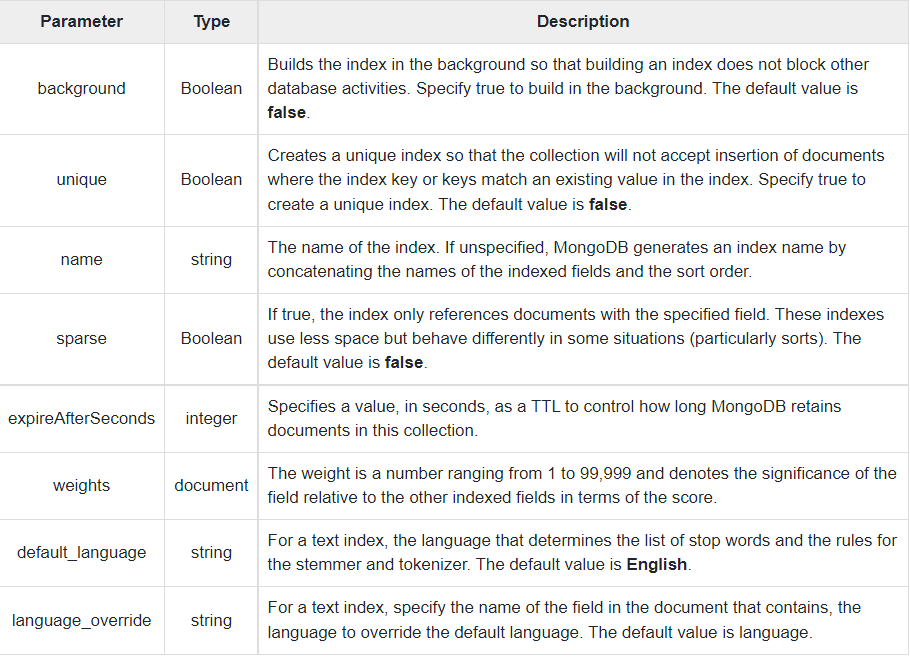

###### Example

In [39]:
films.index_information()

{'_id_': {'v': 2, 'key': [('_id', 1)]}}

In [40]:
films.create_index("year")

'year_1'

In [41]:
films.index_information()

{'_id_': {'v': 2, 'key': [('_id', 1)]},
 'year_1': {'v': 2, 'key': [('year', 1)]}}

In [42]:
stats=films.find({'year_1':'2022'}).explain()
stats['executionStats']

{'executionSuccess': True,
 'nReturned': 0,
 'executionTimeMillis': 0,
 'totalKeysExamined': 0,
 'totalDocsExamined': 22,
 'executionStages': {'stage': 'COLLSCAN',
  'filter': {'year_1': {'$eq': '2022'}},
  'nReturned': 0,
  'executionTimeMillisEstimate': 0,
  'works': 24,
  'advanced': 0,
  'needTime': 23,
  'needYield': 0,
  'saveState': 0,
  'restoreState': 0,
  'isEOF': 1,
  'direction': 'forward',
  'docsExamined': 22},
 'allPlansExecution': []}

In [43]:
films.drop_index('year_1')
print ("Index dropped successfuly")

Index dropped successfuly


# Data visualization

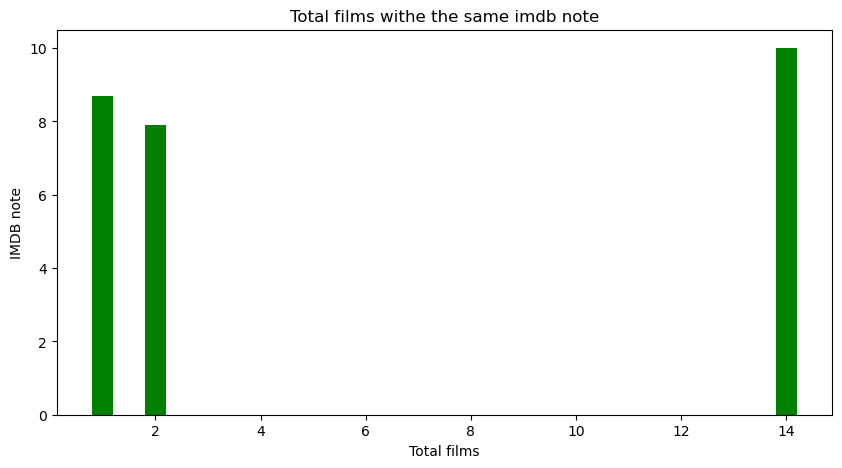

In [44]:
import matplotlib.pyplot as plt

result = films.aggregate([
                                    {"$group" : 
                                         {
                                             "_id" : "$imdb" , 
                                             "Total Films : " :{
                                                                 "$sum" : 1
                                                                } 
                                         }
                                    }
                                ])
  
    
# récupérer nos informations                                  
l_nb = []
l_grade = []
for obj in result :
    l_grade.append(obj["Total Films : "])
    l_nb.append(obj["_id"])

# Création du graphe
plt.figure(figsize = (10, 5))
plt.bar(l_grade, l_nb, color ='green', width = 0.4)
plt.xlabel("Total films")
plt.ylabel("IMDB note")
plt.title("Total films withe the same imdb note")
plt.show()
        
    

In [4]:
result = films.aggregate([{'$group':
                                   {
                                       '_id':'$year',
                                       'sum of imdb : ':{
                                                           '$sum':'$imdb'
                                                       }
                                   }     
                          }
                         ]
                        )

labels = []
sizes = []
for obj in result :
    sizes.append(obj["sum of imdb : "])
    labels.append(obj["_id"])

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

NameError: name 'films' is not defined

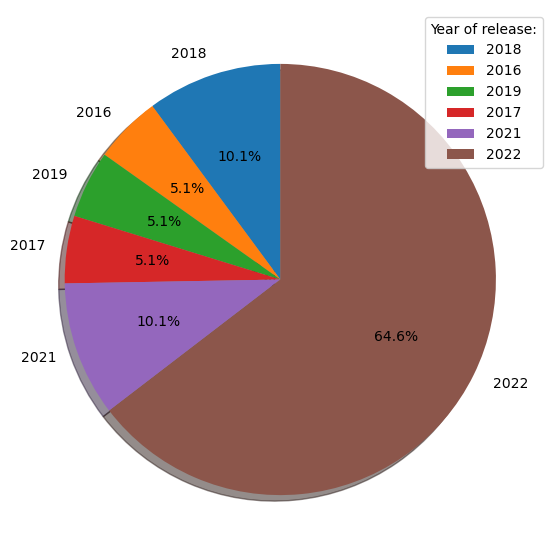

In [80]:
result = films.aggregate([{'$group':
                                   {
                                       '_id':'$year',
                                       'sum of imdb : ':{
                                                           '$sum':'$imdb'
                                                       }
                                   }     
                          }
                         ]
                        )
year = []
imdbsum = []
for obj in result :
    imdbsum.append(obj["sum of imdb : "])
    year.append(obj["_id"])
    

fig = plt.figure(figsize =(10, 7))
plt.pie(imdbsum, labels = year, autopct='%1.1f%%',shadow=True, startangle=90)
plt.legend(title = "Year of release:")
